In [26]:
# Imports & global config
import numpy as np
import numpy.linalg as npl
from scipy.linalg import cho_factor, cho_solve
from scipy.optimize import minimize
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
np.random.seed(42)
print('Versions:',
      'numpy', np.__version__,
      'scipy', __import__('scipy').__version__)
plt.rcParams['figure.figsize'] = (7.5, 3.8)


Versions: numpy 2.0.2 scipy 1.16.3


# Covariance Matters: Likelihoods with Correlated Data

In this notebook, we will talk about statistical inference with correlated uncertainties. We will demonstrate using astronomical examples that not taking correlations into account can result in <font color="orange">**underestimated parameter uncertainties and/or biased parameter estimates**</font>.

## The uncorrelated noise model

The usual model for fitting data is of the form
\begin{equation}
y(x) = m(x;\theta) + \epsilon(x); \hspace{4ex} \epsilon(x) \sim \mathscr{N}(0, \sigma(x)^2)
\end{equation}
That is, the observations deviate from the model predictions only because of <font color="yellow">**iid Gaussian noise**</font>.

A common approach, then, to infer the parameters $\theta$ is to minimize the **chi-square** statistic:

$$
\chi^2(\theta)
=
\displaystyle\sum\limits_{i=1}^{N}
\frac{\left(y_i - m_i(\theta)\right)^2}{\sigma_i^2}.
$$

This is equivalent to assuming that each data point has an independent Gaussian uncertainty of variance $\sigma_i^2$.  
In matrix form, this corresponds to a **diagonal covariance matrix**:

$$
\Sigma = \operatorname{diag}(\sigma_1^2, \sigma_2^2, \dots, \sigma_N^2).
$$

Under this assumption, chi-square minimization is identical to maximizing the Gaussian likelihood

$$
\log \mathcal{L}
=
-\frac{1}{2}\left[
(y - m)^T \Sigma^{-1} (y - m)
+
\log|\Sigma|
+
N\log(2\pi)
\right].
$$

---

### When the Assumption Fails

In many real astronomical datasets, the uncertainties are **not independent**:

- **Time-series** (e.g., light curves, radial-velocity monitoring) show slowly varying atmospheric or instrumental trends.
- **Spectra** processed through **resampling, smoothing, or instrumental convolution** inherit pixel-to-pixel covariance.
- Multiple exposures may share **background subtraction**, **flat-fielding**, or **calibration** steps.
- Broadband photommetry can be correlated when **filters overlap in wavelength** or share **calibration** steps.

In such situations, the true covariance matrix has **non-zero off-diagonal elements**:

$$
\Sigma_{ij} \neq 0 \quad \text{for } i \neq j.
$$

If we still use the diagonal chi-square formulation:

1. <font color="orange">**Parameter estimates can become biased**</font>, because correlated structure in the noise is mistakenly interpreted as part of the signal.
2. <font color="orange">**Uncertainties are underestimated**</font>, because the data contain fewer effectively independent measurements than $N$.

This leads to **overconfident** and potentially **incorrect** scientific conclusions.

---

### The Correct Approach: Likelihood with Full Covariance

To account for correlations, we use the **full Gaussian likelihood**:

$$
\log \mathcal{L}(\theta \mid y, \Sigma)
=
-\frac{1}{2}\left[
(y - m)^T \Sigma^{-1} (y - m)
+
\log|\Sigma|
+
N\log(2\pi)
\right].
$$

- If $\Sigma$ is diagonal, this reduces to ordinary chi-square.
- If $\Sigma$ contains structure (e.g., exponential in time, Toeplitz from smoothing), the likelihood correctly:
  - Down-weights redundant information,
  - Produces **unbiased** parameter estimates,
  - And returns **realistic** uncertainty intervals.

---


## Likelihood with full covariance $\Sigma$

For residual vector $r = y - m(\theta)$ and covariance matrix $\Sigma$, the Gaussian log-likelihood is
$$
\log \mathcal{L} = -\tfrac12 \left[ r^\top \Sigma^{-1} r + \log|\Sigma| + n\log(2\pi) \right].
$$

For a diagonal covariance matrix, the quantity in the brackets reduces to the $\chi^2$.

**We evaluate the full likelihood stably using a <font color="orange">Cholesky factorization/decomposition</font>; we never form $\Sigma^{-1}$ explicitly.**

### Noise models used in this notebook

- **White noise:** $\Sigma = \sigma_w^2 I$ (iid residuals).

- **Ornstein-Uhlenbeck (OU, exponential) covariance:** $k(\Delta t)=\sigma_r^2\exp(-|\Delta t|/\tau)$ + diagonal white noise.

  - Captures **red noise** (low frequency power; long-timescale correlations).

  - Parameters: $\sigma_r$ (red amplitude), $\tau$ (timescale), $\sigma_w$ (white std).

### Spectral covariance from smoothing/resampling

- **Motivation:** Pipeline smoothing/resampling introduces **pixel-to-pixel covariance**.

- **Construction:** Covariance is proportional to the **kernel autocorrelation** → build a **Toeplitz** $\Sigma$; pad beyond support; add small jitter.

- **Usage:** Treat $\Sigma$ as known from the pipeline and plug it into the likelihood.

In [27]:
def loglike_fullcov(residual, Sigma):
    """Gaussian log-likelihood with full covariance using Cholesky.
    Sigma must be symmetric positive-definite.
    """
    c, lower = cho_factor(Sigma, lower=True, check_finite=False)
    alpha = cho_solve((c, lower), residual, check_finite=False)
    quad = residual @ alpha
    logdet = 2.0 * np.sum(np.log(np.diag(c)))
    n = residual.size
    return -0.5 * (quad + logdet + n * np.log(2.0 * np.pi))

def Sigma_white(n, sigma_w):
    return (sigma_w**2) * np.eye(n)

def Sigma_exp_ou(t, sigma_r, tau, sigma_w):
    # Ornstein–Uhlenbeck (exponential) kernel + white noise
    dt = np.abs(t[:, None] - t[None, :])
    K = (sigma_r**2) * np.exp(-dt / tau)
    K[np.diag_indices_from(K)] += sigma_w**2
    return K

def Sigma_from_smoothing(n, sigma_w, kernel):
    """
    Covariance induced by smoothing/resampling with a finite kernel.
    Builds a Toeplitz covariance whose first row is the kernel's
    autocorrelation, normalized so var(lag=0) = sigma_w**2, and
    padded with zeros to length n.
    """
    k = np.asarray(kernel, dtype=float)
    k = k / k.sum()                       # normalize kernel
    ac = fftconvolve(k, k[::-1], mode='full')  # autocorrelation (length 2m-1)
    center = len(ac) // 2

    # first_row for Toeplitz at nonnegative lags: ac[0], ac[1], ...
    first_row = ac[center:]               # length m
    # normalize so variance (lag 0) matches sigma_w**2
    first_row = (sigma_w**2) * first_row / first_row[0]

    # pad with zeros to length n (finite support beyond kernel width)
    if first_row.size < n:
        first_row = np.pad(first_row, (0, n - first_row.size), mode='constant')

    # build Toeplitz from first_row (lags 0..n-1)
    idx = np.arange(n)
    toeplitz = first_row[np.abs(idx[:, None] - idx[None, :])]
    # tiny jitter for SPD
    toeplitz[np.diag_indices_from(toeplitz)] += 1e-12
    return toeplitz

def finite_diff_hessian(func, x, eps=1e-5):
    # Symmetric finite-difference Hessian (small parameter dimension)
    k = len(x)
    H = np.zeros((k, k))
    f0 = func(x)
    for i in range(k):
        dx_i = np.zeros_like(x); dx_i[i] = eps
        f_i1 = func(x + dx_i); f_i2 = func(x - dx_i)
        H[i, i] = (f_i1 - 2*f0 + f_i2) / (eps**2)
        for j in range(i+1, k):
            dx_j = np.zeros_like(x); dx_j[j] = eps
            f_pp = func(x + dx_i + dx_j)
            f_pm = func(x + dx_i - dx_j)
            f_mp = func(x - dx_i + dx_j)
            f_mm = func(x - dx_i - dx_j)
            H[i, j] = H[j, i] = (f_pp - f_pm - f_mp + f_mm) / (4*eps**2)
    return H


## Example A — Time‑correlated light curve (OU noise)
We simulate a sinusoidal signal observed with red (OU) + white noise and fit:
1. an iid model (incorrect), and
2. an OU + white model (correct).

We will compare the parameter recovery and residual autocorrelation from these models.

Synthetic light curve generated.


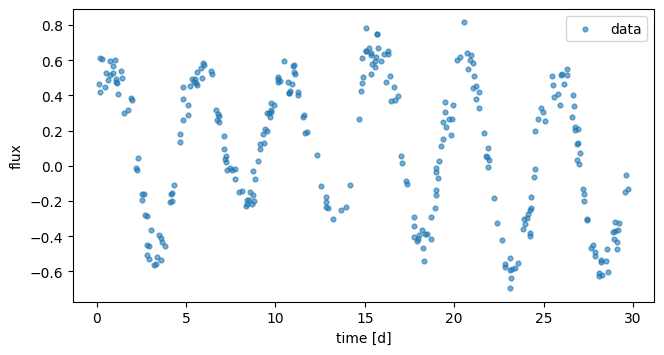

In [28]:
# Ground truth and synthetic data
n = 300
Tspan = 30.0  # days
t = np.sort(np.random.uniform(0, Tspan, n))
P_true = 5.0  # days (assumed known for demo)
A_true = 0.50
phi_true = 0.6
c_true = 0.1
sigma_w_true = 0.05
sigma_r_true = 0.15
tau_true = 1.5

def model_lc(t, A, phi, c, P=P_true):
    return c + A * np.sin(2*np.pi*t/P + phi)

Sigma_true = Sigma_exp_ou(t, sigma_r_true, tau_true, sigma_w_true)
eps = np.linalg.cholesky(Sigma_true) @ np.random.normal(size=n)
y = model_lc(t, A_true, phi_true, c_true) + eps
print('Synthetic light curve generated.')

fig, ax = plt.subplots()
ax.scatter(t, y, s=12, alpha=0.6, label='data')
ax.set_xlabel('time [d]'); ax.set_ylabel('flux'); ax.legend(); plt.show()


### Fit 1: iid (diagonal) likelihood — intentionally misspecified

- **Assumption:** Independent residuals with variance $\sigma_w^2$.

- **Params:** amplitude, phase, offset, $\log\sigma_w$.

- **Expectation:** Overconfident intervals; possible bias, because true noise is red.

In [29]:
# iid fit (incorrect model)
def negloglike_iid(theta):
    A, phi, c, log_sigma_w = theta
    mu = model_lc(t, A, phi, c)
    sigma_w = np.exp(log_sigma_w)
    resid = y - mu
    Sigma = Sigma_white(n, sigma_w)
    return -loglike_fullcov(resid, Sigma)

theta0_iid = np.array([0.3, 0.0, 0.0, np.log(0.1)])
bnds_iid = [(0, None), (-2*np.pi, 2*np.pi), (None, None), (np.log(1e-4), np.log(1.0))]
opt_iid = minimize(negloglike_iid, theta0_iid, bounds=bnds_iid, method='L-BFGS-B')
A_iid, phi_iid, c_iid, logsw_iid = opt_iid.x

H_iid = finite_diff_hessian(negloglike_iid, opt_iid.x)
cov_iid = npl.inv(H_iid + 1e-8*np.eye(H_iid.shape[0]))
errs_iid = np.sqrt(np.diag(cov_iid))
A_iid_err, phi_iid_err, c_iid_err, logsw_iid_err = errs_iid
print('iid fit done.')


iid fit done.


### Fit 2: OU + white likelihood — matches the data-generating noise

- **Assumption:** OU (red) + white residuals.

- **Params:** amplitude, phase, offset, $\log\sigma_w$, $\log\sigma_r$, $\log\tau$.

- **Notes:** Optimize logs to keep positivity; bounds avoid pathological values.

In [30]:
# OU + white (correct model)
def negloglike_ou(theta):
    A, phi, c, log_sigma_w, log_sigma_r, log_tau = theta
    mu = model_lc(t, A, phi, c)
    sigma_w = np.exp(log_sigma_w)
    sigma_r = np.exp(log_sigma_r)
    tau = np.exp(log_tau)
    resid = y - mu
    Sigma = Sigma_exp_ou(t, sigma_r, tau, sigma_w)
    return -loglike_fullcov(resid, Sigma)

theta0_ou = np.array([0.3, 0.0, 0.0, np.log(0.1), np.log(0.1), np.log(1.0)])
bnds_ou = [(0, None), (-2*np.pi, 2*np.pi), (None, None),
           (np.log(1e-4), np.log(1.0)), (np.log(1e-4), np.log(1.0)), (np.log(1e-2), np.log(30.0))]
opt_ou = minimize(negloglike_ou, theta0_ou, bounds=bnds_ou, method='L-BFGS-B')
A_ou, phi_ou, c_ou, lsw_ou, lsr_ou, ltau_ou = opt_ou.x

H_ou = finite_diff_hessian(negloglike_ou, opt_ou.x)
cov_ou = npl.inv(H_ou + 1e-8*np.eye(H_ou.shape[0]))
errs_ou = np.sqrt(np.diag(cov_ou))
A_ou_err, phi_ou_err, c_ou_err = errs_ou[:3]
print('OU fit done.')


OU fit done.


### Interpreting the light‑curve results

- **Curves:** Dashed = iid; Solid = OU.

- **Uncertainties:** OU-aware fit should be closer to truth and have **wider but honest** error bars.

- **Diagnostic:** Residual autocorrelation function (ACF) — a good noise model leaves a **flat ACF** (no structure).

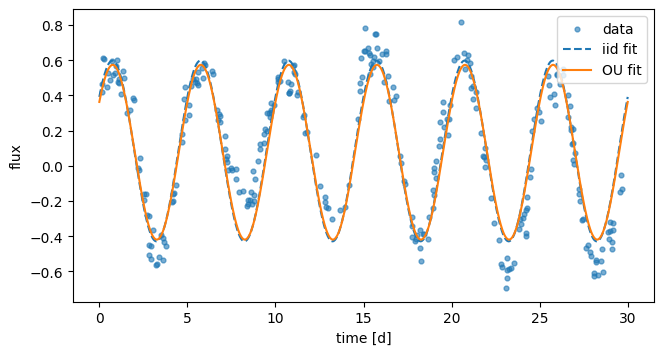

Truth  A, phi, c : 0.500, 0.600, 0.100
iid    A, phi, c : 0.513±0.011, 0.641±0.022, 0.084±0.008
OU     A, phi, c : 0.496±0.029,  0.613±0.058, 0.077±0.036


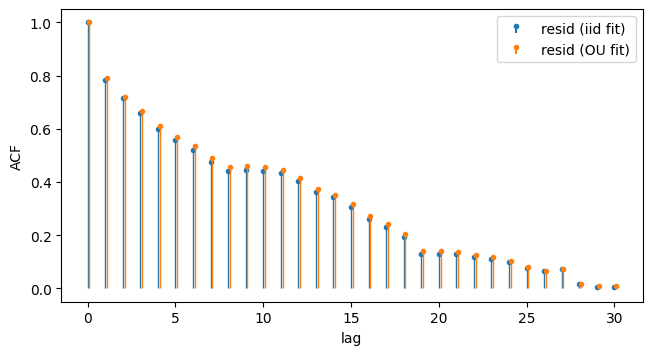

In [31]:
# Visualization & numeric comparison (Example A)
tt = np.linspace(0, Tspan, 1000)
fig, ax = plt.subplots()
ax.scatter(t, y, s=12, alpha=0.6, label='data')
ax.plot(tt, model_lc(tt, A_iid, phi_iid, c_iid), ls='--', label='iid fit')
ax.plot(tt, model_lc(tt, A_ou,  phi_ou,  c_ou),  ls='-',  label='OU fit')
ax.set_xlabel('time [d]'); ax.set_ylabel('flux'); ax.legend(); plt.show()

print(f'Truth  A, phi, c : {A_true:.3f}, {phi_true:.3f}, {c_true:.3f}')
print(f'iid    A, phi, c : {A_iid:.3f}±{A_iid_err:.3f}, {phi_iid:.3f}±{phi_iid_err:.3f}, {c_iid:.3f}±{c_iid_err:.3f}')
print(f'OU     A, phi, c : {A_ou:.3f}±{A_ou_err:.3f},  {phi_ou:.3f}±{phi_ou_err:.3f}, {c_ou:.3f}±{c_ou_err:.3f}')

def acf(x, maxlag=30):
    x = x - x.mean()
    c = np.correlate(x, x, mode='full')
    mid = len(c)//2
    c = c[mid:mid+maxlag+1]
    return c / c[0]

r_iid = y - model_lc(t, A_iid, phi_iid, c_iid)
r_ou  = y - model_lc(t, A_ou,  phi_ou,  c_ou)
lags = np.arange(31)
fig, ax = plt.subplots()

stem_iid = ax.stem(lags, acf(r_iid, 30))
stem_ou  = ax.stem(lags + 0.1, acf(r_ou, 30))

# Style lines explicitly
for stem in (stem_iid, stem_ou):
    stem.markerline.set_marker("o")
    stem.markerline.set_markersize(3)
    stem.stemlines.set_linewidth(1.0)
    stem.baseline.set_visible(False)

stem_iid.markerline.set_color("C0")
stem_iid.stemlines.set_color("C0")

stem_ou.markerline.set_color("C1")
stem_ou.stemlines.set_color("C1")

ax.set_xlabel('lag'); ax.set_ylabel('ACF'); ax.legend(['resid (iid fit)', 'resid (OU fit)']); plt.show()


The fits look similar because the **mean model** is the same in both cases. However, the **parameter uncertainties** are much more realistic now. This is typically how changing the noise model affects inference.

The residual ACF shows structure for both fits; this is **by design**, because we are computing the ACF from the raw residuals. We should be testing the **whitened residuals** instead: $z = L^{-1}(y - m)$, where $L$ is any lower triangular matrix such that $LL^{\rm T} = \Sigma$ (this is nothing but the Cholesky decomposition of $\Sigma$).

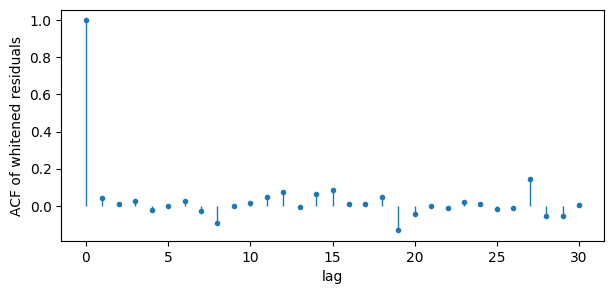

Whitened residuals: mean ~ 0.013, std ~ 1.000


In [32]:
# Whitened residuals diagnostic for OU model
from scipy.linalg import cho_factor, cho_solve

# build Sigma with MLE hyperparameters
sigma_w = np.exp(lsw_ou); sigma_r = np.exp(lsr_ou); tau = np.exp(ltau_ou)
mu_ou = model_lc(t, A_ou, phi_ou, c_ou)
resid_ou = y - mu_ou
Sigma_ou = Sigma_exp_ou(t, sigma_r, tau, sigma_w)

# z = L^{-1} r where LL^T = Sigma
c, lower = cho_factor(Sigma_ou, lower=True, check_finite=False)
z_ou = cho_solve((c, lower), resid_ou, check_finite=False)  # this yields Sigma^{-1} r
# Turn Sigma^{-1} r into whitened residuals: solve L^T z = Sigma^{-1} r ⇒ z = (L^T)^{-1} (Sigma^{-1} r)
# A simpler way: draw standard normals u, compare r vs. L u; here we compute t = L^{-1} r directly:
# t = solve triangular L with resid_ou:
from scipy.linalg import solve_triangular
t_ou = solve_triangular(c, resid_ou, lower=True, check_finite=False)  # t ~ N(0, I) if model is right

# Now test t_ou, not resid_ou
def acf_regular(x, maxlag=30):
    x = x - x.mean()
    c = np.correlate(x, x, mode='full'); mid = len(c)//2
    c = c[mid:mid+maxlag+1]; return c/c[0]

import matplotlib.pyplot as plt
import numpy as np
lags = np.arange(31)
fig, ax = plt.subplots(figsize=(7,3))
stem = ax.stem(lags, acf_regular(t_ou, 30))
stem.markerline.set_marker("o"); stem.markerline.set_markersize(3)
stem.stemlines.set_linewidth(1.0); stem.baseline.set_visible(False)
ax.set_xlabel("lag"); ax.set_ylabel("ACF of whitened residuals")
plt.show()

# Optional sanity checks:
print(f"Whitened residuals: mean ~ {t_ou.mean():.3f}, std ~ {t_ou.std():.3f}")


<font color="yellow">The ACF is now consistent with a zero-mean, unit-variance distribution.</font> Yay!

We can also quantify the correlation strength and compare it to the cadence of the data:

In [33]:
dt_med = np.median(np.diff(np.sort(t)))
rho1 = np.exp(-dt_med / np.exp(ltau_ou))
print(f"Median cadence = {dt_med:.3f} days;  implied lag-1 corr = {rho1:.3f}")


Median cadence = 0.068 days;  implied lag-1 corr = 0.946


### Interpreting the Correlation Strength in Example A

We computed:

- Median cadence:  
  $$
  \Delta t_{\mathrm{med}} = 0.06805 \ \text{days} \approx 1.63 \ \text{hours}
  $$
- Implied lag-1 correlation under the fitted OU model:  
  $$
  \rho_1 = \exp(-\Delta t_{\mathrm{med}} / \tau) = 0.946
  $$

This value of $\rho_1$ is **very high**. It means:

1. <font color="orange">**Adjacent points are strongly correlated.**</font>  
   Each measurement contains much of the same information as its neighbors. The noise has a **long memory** compared to the sampling interval.

2. The corresponding **correlation timescale** can be estimated by solving for $\tau$:
   $$
   \tau \approx -\frac{\Delta t_{\mathrm{med}}}{\ln \rho_1}
   $$
   Substituting the numbers:
   $$
   \tau \approx -\frac{0.06805}{\ln(0.946)} \approx 1.2 \ \text{days}
   $$
   So <font color="orange">the correlated noise evolves slowly, over a timescale of **~1.2 days**</font>.

3. This implies <font color="orange">the effective number of **independent** data points is much smaller than the total number of samples.</font>  
   For an AR(1)-like process, a common heuristic approximation is:
   $$
   N_{\mathrm{eff}} \approx N \,\frac{1 - \rho_1}{1 + \rho_1}
   $$
   With $\rho_1 = 0.946$, this ratio is:
   $$
   \frac{1 - \rho_1}{1 + \rho_1}
   \approx
   \frac{0.054}{1.946}
   \approx 0.028
   $$
   <font color="orange">**This means only ~3% of the points carry independent information**</font>.

---

### Consequences for the Fits

- The **mean model curves** from the IID fit and the OU fit will look visually very similar because the deterministic model is the same.
- The **difference shows up in the uncertainties**:
  - The IID (diagonal covariance) fit **overstates** how much data there really is, producing unrealistically small error bars.
  - The OU (correlated) likelihood **correctly inflates** the uncertainties to reflect the reduced effective information.
- The raw-residual ACF will **not** go flat under OU.  
  This is expected. **The OU model explains the correlation**, it does **not remove it** from the raw residuals.

To test whether the OU model is appropriate, we must examine the **whitened residuals**:
$$
t = L^{-1}(y - m)
\quad \text{where } LL^T = \Sigma.
$$
If the model captures the noise correctly, the whitened residuals $t$ should be approximately:
- zero-mean,
- unit variance,
- and have an **ACF consistent with white noise**.

---

### Key Takeaway

The high lag-1 correlation ($\rho_1 \approx 0.95$) means the noise is **strongly red relative to the sampling cadence**.  
Ignoring this (i.e., using standard $\chi^2$ with diagonal $\Sigma$) leads to:

- **Underestimated uncertainties**, and
- Potentially **biased** parameter estimates.

<font color="orange">Using the full-covariance likelihood is therefore **not optional** here — it is necessary for scientifically reliable inference.</font>


## Example B — Correlated spectral pixels (resampling/smoothing)

<font color="yellow">Resampling and smoothing introduce pixel-to-pixel covariance. The combination of a Gaussian spectral line and white noise, followed by smoothing (which mimics pipeline effects) results in neighboring pixels becoming correlated.</font>

To model such a spectrum, we construct a covariance that is proportional to the **kernel autocorrelation**.

We will then fit a Gaussian to the line profile with both the diagonal covariance matrix and with the covariance matrix constructed above.

Synthetic spectrum generated.


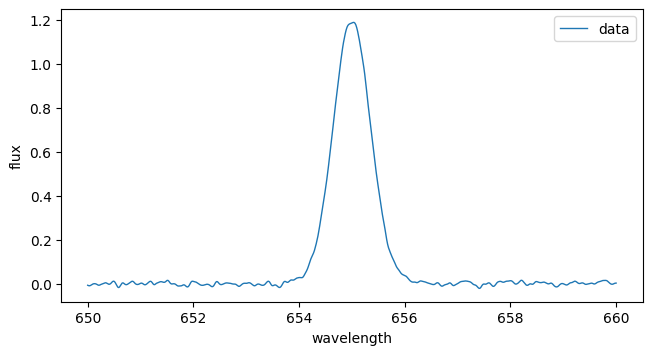

In [34]:
# Synthetic spectrum with smoothing-induced covariance
wl = np.linspace(650.0, 660.0, 600)
n_spec = wl.size

amp_true = 1.2; mu_true = 655.0; sig_true = 0.35; cont_true = 0.0
def gauss(x, amp, mu, sig, cont):
    return cont + amp * np.exp(-0.5*((x-mu)/sig)**2)

flux_ideal = gauss(wl, amp_true, mu_true, sig_true, cont_true)
sigma_w_spec = 0.02
raw_noise = np.random.normal(0.0, sigma_w_spec, size=n_spec)
kernel = np.exp(-0.5*((np.arange(-5, 6))/2.0)**2)  # 11-pixel Gaussian kernel
noise_corr = fftconvolve(raw_noise, kernel/kernel.sum(), mode='same')
flux = flux_ideal + noise_corr
Sigma_spec = Sigma_from_smoothing(n_spec, sigma_w_spec, kernel)
print('Synthetic spectrum generated.')

fig, ax = plt.subplots()
ax.plot(wl, flux, lw=1, label='data')
ax.set_xlabel('wavelength'); ax.set_ylabel('flux'); ax.legend()



### Spectral Fit 1: iid likelihood

In [35]:
# iid spectral fit
def negloglike_spec_iid(theta):
    amp, mu, sig, cont, log_sigma = theta
    muvec = gauss(wl, amp, mu, sig, cont)
    resid = flux - muvec
    Sigma = Sigma_white(n_spec, np.exp(log_sigma))
    return -loglike_fullcov(resid, Sigma)

x0_iid = np.array([1.0, 655.2, 0.25, 0.0, np.log(0.02)])
bnds_iid = [(0, None), (wl.min(), wl.max()), (1e-3, 2.0), (None, None), (np.log(1e-4), np.log(0.2))]
opt_iid_spec = minimize(negloglike_spec_iid, x0_iid, bounds=bnds_iid, method='L-BFGS-B')
H_iid_spec = finite_diff_hessian(negloglike_spec_iid, opt_iid_spec.x)
cov_iid_spec = npl.inv(H_iid_spec + 1e-8*np.eye(H_iid_spec.shape[0]))
errs_iid_spec = np.sqrt(np.diag(cov_iid_spec))
print('iid spectral fit done.')


iid spectral fit done.


### Spectral Fit 2: full‑$\Sigma$ likelihood (pipeline‑derived covariance)

- **Assumption:** $\Sigma$ is known from the pipeline's kernel.

- **Outcome:** More realistic uncertainties; flatter residual ACF.

In [36]:
# Full-Σ spectral fit (Σ known from pipeline effects)
def negloglike_spec_full(theta):
    amp, mu, sig, cont = theta
    muvec = gauss(wl, amp, mu, sig, cont)
    resid = flux - muvec
    return -loglike_fullcov(resid, Sigma_spec)

x0_full = np.array([1.0, 655.2, 0.25, 0.0])
bnds_full = [(0, None), (wl.min(), wl.max()), (1e-3, 2.0), (None, None)]
opt_full_spec = minimize(negloglike_spec_full, x0_full, bounds=bnds_full, method='L-BFGS-B')
H_full_spec = finite_diff_hessian(negloglike_spec_full, opt_full_spec.x)
cov_full_spec = npl.inv(H_full_spec + 1e-8*np.eye(H_full_spec.shape[0]))
errs_full_spec = np.sqrt(np.diag(cov_full_spec))
print('Full-Σ spectral fit done.')


Full-Σ spectral fit done.


### Comparing results of modeling

- Mean fits are often visually similar.
- Uncertainties are more realistic when a proper covariance matrix is considered.
- The autocorrelation function (ACF) should show no structure if a proper covariance matrix is chosen for the problem, BUT one should compute the ACF for the whitened residues.

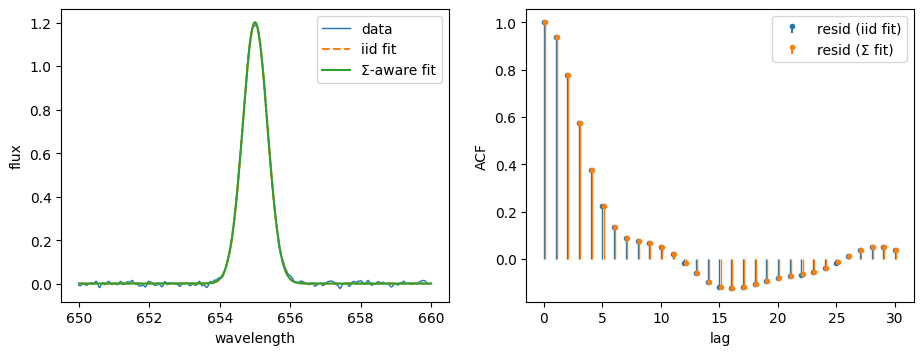

Truth (amp, mu, sig): (1.2, 655.0, 0.35)
iid   params ±1σ     : [  1.1994 655.0002   0.3511] ± [0.0015 0.0005 0.0005]
Σ-fit params ±1σ     : [  1.1995 655.0002   0.3511] ± [0.0107 0.0036 0.0037]


In [37]:
# Visualization & numeric comparison (Example B)
fig, ax = plt.subplots(1, 2, figsize=(11, 3.8))
ax[0].plot(wl, flux, lw=1, label='data')
ax[0].plot(wl, gauss(wl, *opt_iid_spec.x[:4]), '--', label='iid fit')
ax[0].plot(wl, gauss(wl, *opt_full_spec.x[:4]), '-',  label='Σ-aware fit')
ax[0].set_xlabel('wavelength'); ax[0].set_ylabel('flux'); ax[0].legend()

def acf_uniform(x, maxlag=30):
    x = x - x.mean()
    c = np.correlate(x, x, mode='full'); mid = len(c)//2
    c = c[mid:mid+maxlag+1]; return c/c[0]

r_iid  = flux - gauss(wl, *opt_iid_spec.x[:4])
r_full = flux - gauss(wl, *opt_full_spec.x[:4])

lags = np.arange(31)
stem_iid  = ax[1].stem(lags, acf_uniform(r_iid, 30))
stem_full = ax[1].stem(lags + 0.1, acf_uniform(r_full, 30))

for stem in (stem_iid, stem_full):
    stem.markerline.set_marker("o")
    stem.markerline.set_markersize(3)
    stem.stemlines.set_linewidth(1.0)
    stem.baseline.set_visible(False)

stem_iid.markerline.set_color("C0")
stem_iid.stemlines.set_color("C0")

stem_full.markerline.set_color("C1")
stem_full.stemlines.set_color("C1")

ax[1].set_xlabel('lag'); ax[1].set_ylabel('ACF'); ax[1].legend(['resid (iid fit)', 'resid (Σ fit)'])
plt.show()

print('Truth (amp, mu, sig):', (1.2, 655.0, 0.35))
np.set_printoptions(precision=4, suppress=True)
print(f'iid   params ±1σ     : {opt_iid_spec.x[:3]} ± {errs_iid_spec[:3]}')
print(f'Σ-fit params ±1σ     : {opt_full_spec.x[:3]} ± {errs_full_spec[:3]}')


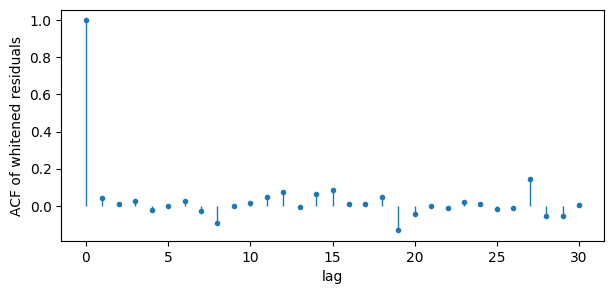

Whitened residuals: mean ~ 0.013, std ~ 1.000


In [38]:
# Whitened residuals diagnostic for OU model
from scipy.linalg import cho_factor, cho_solve

# build Sigma with MLE hyperparameters
sigma_w = np.exp(lsw_ou); sigma_r = np.exp(lsr_ou); tau = np.exp(ltau_ou)
mu_ou = model_lc(t, A_ou, phi_ou, c_ou)
resid_ou = y - mu_ou
Sigma_ou = Sigma_exp_ou(t, sigma_r, tau, sigma_w)

# z = L^{-1} r where LL^T = Sigma
c, lower = cho_factor(Sigma_ou, lower=True, check_finite=False)
z_ou = cho_solve((c, lower), resid_ou, check_finite=False)  # this yields Sigma^{-1} r
# Turn Sigma^{-1} r into whitened residuals: solve L^T z = Sigma^{-1} r ⇒ z = (L^T)^{-1} (Sigma^{-1} r)
# A simpler way: draw standard normals u, compare r vs. L u; here we compute t = L^{-1} r directly:
# t = solve triangular L with resid_ou:
from scipy.linalg import solve_triangular
t_ou = solve_triangular(c, resid_ou, lower=True, check_finite=False)  # t ~ N(0, I) if model is right

# Now test t_ou, not resid_ou
def acf_regular(x, maxlag=30):
    x = x - x.mean()
    c = np.correlate(x, x, mode='full'); mid = len(c)//2
    c = c[mid:mid+maxlag+1]; return c/c[0]

import matplotlib.pyplot as plt
import numpy as np
lags = np.arange(31)
fig, ax = plt.subplots(figsize=(7,3))
stem = ax.stem(lags, acf_regular(t_ou, 30))
stem.markerline.set_marker("o"); stem.markerline.set_markersize(3)
stem.stemlines.set_linewidth(1.0); stem.baseline.set_visible(False)
ax.set_xlabel("lag"); ax.set_ylabel("ACF of whitened residuals")
plt.show()

# Optional sanity checks:
print(f"Whitened residuals: mean ~ {t_ou.mean():.3f}, std ~ {t_ou.std():.3f}")


In [39]:
dt_med = np.median(np.diff(np.sort(t)))
rho1 = np.exp(-dt_med / np.exp(ltau_ou))
print(f"Median cadence = {dt_med:.3f} days;  implied lag-1 corr = {rho1:.3f}")


Median cadence = 0.068 days;  implied lag-1 corr = 0.946


## Practical notes
- If $\Sigma$ has structure (Toeplitz/banded), specialized solvers are much faster.
- For production, prefer MCMC/VI for parameter intervals; the finite-difference Hessian is for instructive purposes only.
- Always examine residual autocorrelation; it should be flat if the likelihood matches the noise.

## Posterior Inference via MCMC: IID vs OU Noise (Example A)

We compare the **posterior** under two noise models on the same light-curve data:

- **IID (diagonal $\Sigma$):** parameters $(A,\ \phi,\ c,\ \log\sigma_w)$
- **OU + white:** parameters $(A,\ \phi,\ c,\ \log\sigma_w,\ \log\sigma_r,\ \log\tau)$

We use a compact **Metropolis–Hastings** sampler implemented below (no external libraries). Priors are weak box priors matching the optimization bounds.

In [40]:
import numpy as np, matplotlib.pyplot as plt

# Box priors using earlier bounds
bnds_iid = [(0, None), (-2*np.pi, 2*np.pi), (None, None), (np.log(1e-4), np.log(1.0))]
bnds_ou  = [(0, None), (-2*np.pi, 2*np.pi), (None, None),
            (np.log(1e-4), np.log(1.0)), (np.log(1e-4), np.log(1.0)), (np.log(1e-2), np.log(30.0))]

def log_prior_box(theta, bnds):
    for x,(lo,hi) in zip(theta, bnds):
        if lo is not None and x < lo: return -np.inf
        if hi is not None and x > hi: return -np.inf
    return 0.0

def logpost_iid(theta):
    lp = log_prior_box(theta, bnds_iid)
    if not np.isfinite(lp): return -np.inf
    return lp - negloglike_iid(theta)

def logpost_ou(theta):
    lp = log_prior_box(theta, bnds_ou)
    if not np.isfinite(lp): return -np.inf
    return lp - negloglike_ou(theta)

def mh_sampler(logpost, x0, step, nsamples=5000, burn=1500, thin=3, seed=42):
    rng = np.random.default_rng(seed)
    x = np.array(x0, dtype=float)
    cur = logpost(x)
    chain = []
    accepts = 0
    for i in range(nsamples*thin + burn):
        prop = x + rng.normal(scale=step, size=x.size)
        # wrap phi into [-pi, pi]
        if prop.size >= 2:
            if prop[1] < -np.pi: prop[1] += 2*np.pi
            if prop[1] >  np.pi: prop[1] -= 2*np.pi
        lp = logpost(prop)
        if np.log(rng.random()) < (lp - cur):
            x, cur = prop, lp
            accepts += 1
        if i >= burn and (i - burn) % thin == 0:
            chain.append(x.copy())
    return np.array(chain), accepts / (nsamples*thin + burn)

# Run IID
x0_iid = opt_iid.x
step_iid = np.array([0.02, 0.05, 0.02, 0.05])
post_iid, acc_iid = mh_sampler(logpost_iid, x0_iid, step_iid, nsamples=6000, burn=2000, thin=3, seed=123)
print("IID MCMC: chain", post_iid.shape, "accept", round(acc_iid,3))

# Run OU
x0_ou = opt_ou.x
step_ou = np.array([0.02, 0.05, 0.02, 0.05, 0.05, 0.05])
post_ou, acc_ou = mh_sampler(logpost_ou, x0_ou, step_ou, nsamples=7000, burn=2500, thin=3, seed=456)
print("OU  MCMC: chain", post_ou.shape, "accept", round(acc_ou,3))

IID MCMC: chain (6000, 4) accept 0.123
OU  MCMC: chain (7000, 6) accept 0.472


In [41]:
# Posterior summaries (median and central 68%)
def summarize(chain, names):
    qs = np.quantile(chain, [0.16, 0.5, 0.84], axis=0)
    for i,n in enumerate(names):
        lo, med, hi = qs[:,i]
        print(f"{n:>12s}: {med: .5f}  (-{med-lo:.5f}, +{hi-med:.5f})")

print("IID posteriors:")
summarize(post_iid, ["A","phi","c","log_sigma_w"])
print("\nOU posteriors:")
summarize(post_ou,  ["A","phi","c","log_sigma_w","log_sigma_r","log_tau"])

IID posteriors:
           A:  0.51255  (-0.01068, +0.01162)
         phi:  0.64037  (-0.02113, +0.02321)
           c:  0.08429  (-0.00753, +0.00733)
 log_sigma_w: -1.99501  (-0.04067, +0.03902)

OU posteriors:
           A:  0.49306  (-0.03015, +0.03022)
         phi:  0.61783  (-0.05927, +0.05982)
           c:  0.07615  (-0.04853, +0.04325)
 log_sigma_w: -2.97806  (-0.06929, +0.07112)
 log_sigma_r: -1.95316  (-0.17345, +0.24454)
     log_tau:  0.41217  (-0.46115, +0.50465)


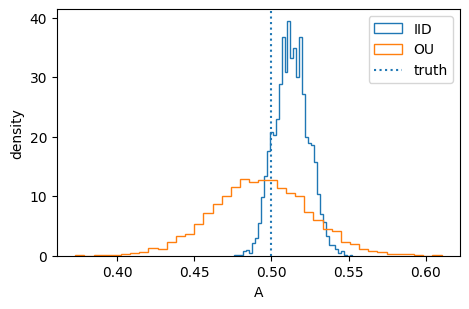

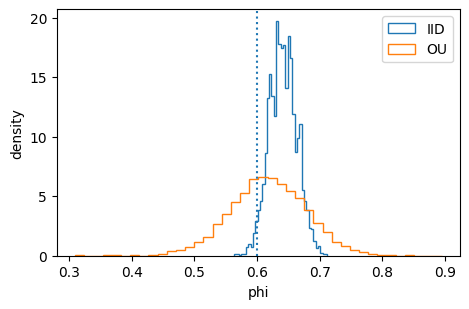

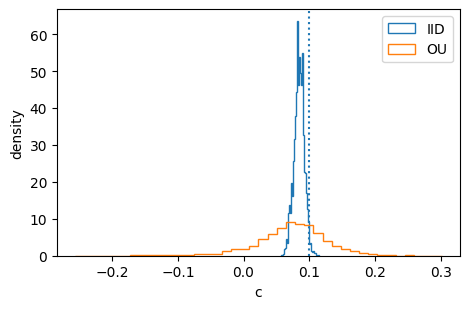

In [42]:
# Visual comparison for shared parameters
def compare_hist(chain_iid, chain_ou, idx, name):
    plt.figure(figsize=(5.2,3.2))
    plt.hist(chain_iid[:,idx], bins=40, density=True, histtype='step', label='IID')
    plt.hist(chain_ou[:,idx],  bins=40, density=True, histtype='step', label='OU')
    if idx == 0: plt.axvline(A_true, linestyle=':', label='truth')
    if idx == 1: plt.axvline(phi_true, linestyle=':')
    if idx == 2: plt.axvline(c_true, linestyle=':')
    plt.xlabel(name); plt.ylabel("density"); plt.legend(); plt.show()

compare_hist(post_iid, post_ou, 0, "A")
compare_hist(post_iid, post_ou, 1, "phi")
compare_hist(post_iid, post_ou, 2, "c")

# Note that the iid method is producing biased parameter estimates!!
# The OU method's larger (more realistic) uncertainties reduce this bias.

### Corner-style Posterior Comparison (IID vs OU)

We plot triangular (corner-style) projections for the **shared parameters** $(A,\ \phi,\ c)$.  
Left: IID model. Right: OU model. The diagonals show 1D histograms; off-diagonals show 2D density via `hist2d`.

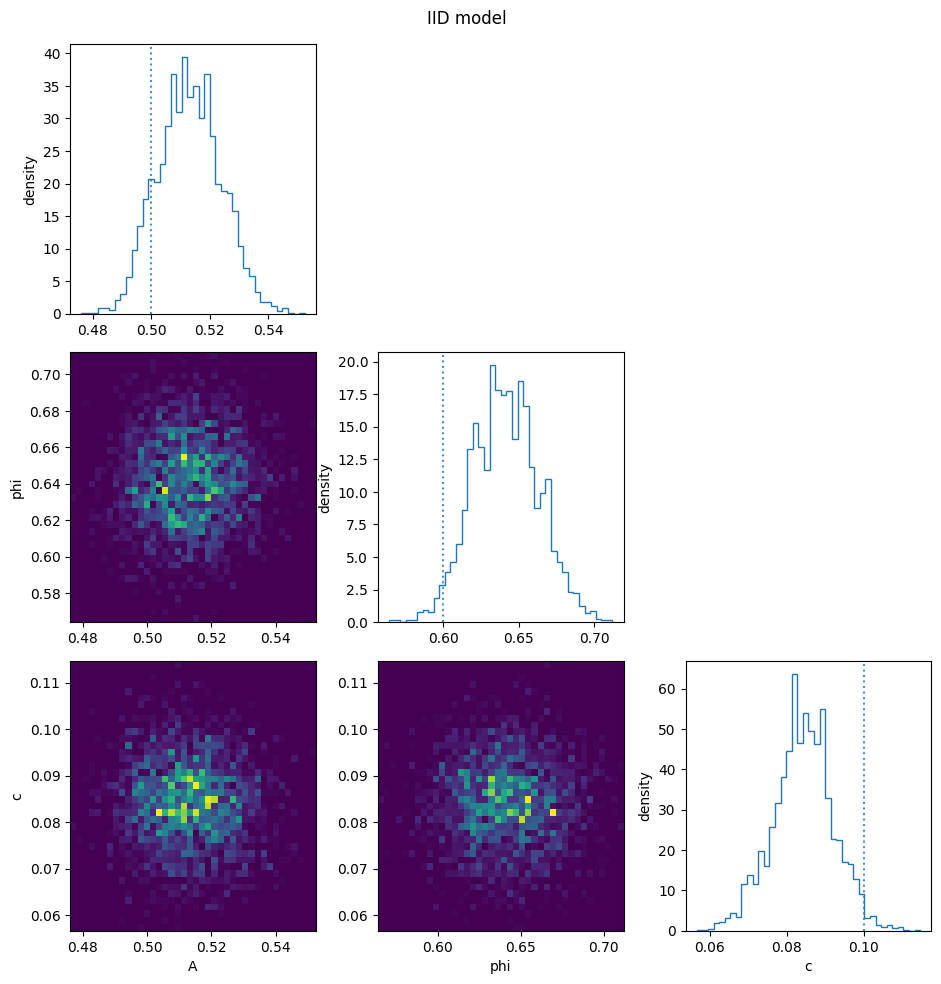

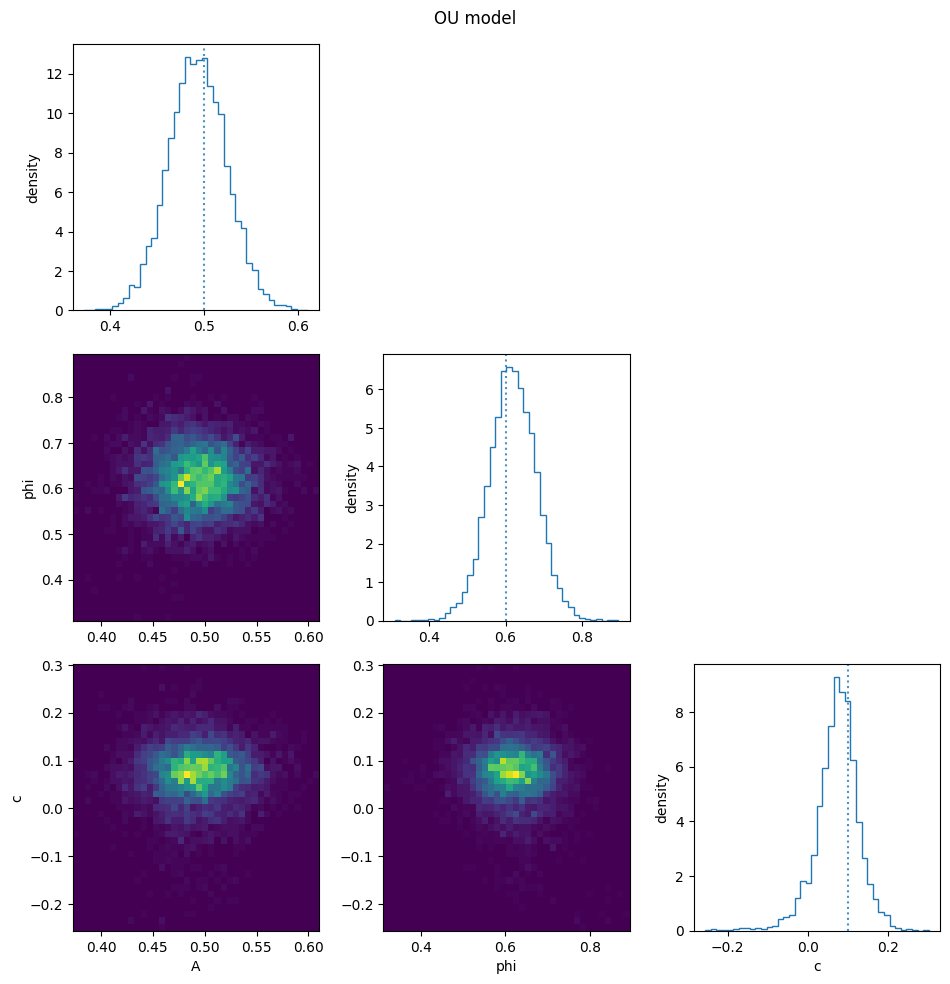

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def corner_simple(chain, labels, truths=None, bins=40):
    k = len(labels)
    fig, axes = plt.subplots(k, k, figsize=(3.2*k, 3.2*k))
    for i in range(k):
        for j in range(k):
            ax = axes[i, j]
            if i == j:
                ax.hist(chain[:, j], bins=bins, density=True, histtype='step')
                if truths is not None:
                    ax.axvline(truths[j], linestyle=':', alpha=0.8)
                ax.set_ylabel("density")
            elif i > j:
                h = ax.hist2d(chain[:, j], chain[:, i], bins=bins)
            else:
                ax.axis('off')
            if i == k-1 and j <= i:
                ax.set_xlabel(labels[j])
            if j == 0 and i > 0:
                ax.set_ylabel(labels[i])
    plt.tight_layout()
    return fig, axes

labels_shared = ["A", "phi", "c"]
truths_shared = [A_true, phi_true, c_true]

# IID corner
fig1, _ = corner_simple(post_iid[:, :3], labels_shared, truths=truths_shared)
fig1.suptitle("IID model", y=1.02)
plt.show()

# OU corner
fig2, _ = corner_simple(post_ou[:, :3], labels_shared, truths=truths_shared)
fig2.suptitle("OU model", y=1.02)
plt.show()

**Reading the plots.** Compare widths (marginals on the diagonals) and covariances (tilt/spread of 2D panels).  
With strongly correlated noise, the OU posteriors should be **wider** and sometimes differently oriented, reflecting the revised weighting of the data.